In [65]:
# Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

In [66]:
# Carga de data
data = pd.read_csv("../data/data.csv")

In [67]:
# DataFrame solo Uruguay, Montevideo y ventas
df = data[(data["l1"] == "Uruguay") & 
            (data["l2"] == "Montevideo") & 
            (data["operation_type"] == "Venta")]

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2950 entries, 1818 to 999665
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2950 non-null   object 
 1   ad_type          2950 non-null   object 
 2   start_date       2950 non-null   object 
 3   end_date         2950 non-null   object 
 4   created_on       2950 non-null   object 
 5   lat              2882 non-null   float64
 6   lon              2882 non-null   float64
 7   l1               2950 non-null   object 
 8   l2               2950 non-null   object 
 9   l3               608 non-null    object 
 10  l4               0 non-null      object 
 11  l5               0 non-null      object 
 12  l6               0 non-null      float64
 13  rooms            1887 non-null   float64
 14  bedrooms         2311 non-null   float64
 15  bathrooms        2689 non-null   float64
 16  surface_total    2397 non-null   float64
 17  surface_covere

In [69]:
# Revision de registros duplicados
df.duplicated().sum()

np.int64(0)

In [70]:
# Tratar valores faltantes
porcentaje_faltantes = df.isna().sum() / len(df) * 100
print(porcentaje_faltantes[porcentaje_faltantes > 0].sort_values(ascending=False))

l5                 100.000000
l4                 100.000000
l6                 100.000000
l3                  79.389831
rooms               36.033898
bedrooms            21.661017
surface_covered     20.983051
surface_total       18.745763
price_period         9.966102
bathrooms            8.847458
lat                  2.305085
lon                  2.305085
currency             1.288136
price                1.254237
dtype: float64


In [71]:
# Elimino columnas que no aportan información
df = df.drop(columns=['l4', 'l5', 'l6'])

In [72]:
# Eliminar filas donde price, currency, lon y lat son NaN
df = df.dropna(subset=['price'])
df = df.dropna(subset=['currency'])
df = df.dropna(subset=['lon'])
df = df.dropna(subset=['lat'])

In [73]:
# Identificar barrios en la columna 'title' para rellenar l3
## Lista de barrios sin tildes y en minúsculas
barrios = [
    'ciudad vieja', 'centro', 'cordon', 'pocitos', 'punta carretas', 'parque rodo', 'tres cruces',
    'palermo', 'parque batlle', 'buceo', 'punta gorda', 'malvin', 'malvin norte', 'carrasco',
    'carrasco norte', 'carrasco este', 'carrasco sur', 'prado', 'sayago', 'la blanqueada',
    'aires puros', 'union', 'paso de la arena', 'punta rieles', 'casabo', 'villa del cerro',
    'goes', 'nuevo paris', 'bella vista', 'larrañaga', 'la teja', 'capurro', 'manga',
    'parque guarani', 'maronas', 'colon', 'jacinto vera', 'brazo oriental', 'banados de carrasco',
    'barrio sur', 'aguada', 'paso de las duranas', 'la comercial', 'colon sureste', 'pque. batlle',
    'la figurita', 'lezica', 'villa garcia', 'las canteras', 'atahualpa', 'reducto',
    'tres ombues', 'villa espanola', 'mercado modelo', 'villa munoz', 'penarol', 'cerrito',
    'conciliacion', 'colon centro', 'castro', 'manga toledo chico', 'ituzaingo', 'jardines del hipodromo',
    'la paloma', 'pta. rieles', 'las acacias', 'piedras blancas', 'belvedere', 'flor de maronas', 'cerro'
]

## Función para quitar tildes y pasar a minúsculas
def limpiar_texto(texto):
    if pd.isna(texto):
        return texto
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    return texto.lower()

## Crear una columna temporal en minúsculas y sin tildes para la búsqueda
df['title_clean'] = df['title'].apply(limpiar_texto)

## Función para extraer barrio
def extraer_barrio(texto):
    if pd.isna(texto):
        return None
    for barrio in barrios:
        if barrio in texto:
            return barrio.title()  # capitaliza correctamente
    return None

## Llenar l3 solo donde era NaN
df['l3'] = df['l3'].fillna(df['title_clean'].apply(extraer_barrio))

## Reemplazar los NaN restantes por 'sin info'
df['l3'] = df['l3'].fillna('sin info')

# Para obtenerse los barrios que no se pudieron asignar pueden usarse los datos de lon y lat asignar el 
#barrio correspondiente.


In [74]:
# Reemplazar los NaN de rooms, bedrooms y bathrooms por la media según property_type
df = df.copy()
cols_to_fill = ['rooms', 'bedrooms', 'bathrooms']

# Reemplazar NaN por la media según property_type
for col in cols_to_fill:
    df.loc[:, col] = df[col].fillna(df.groupby('property_type')[col].transform('mean'))
    # Reemplazar los NaN restantes por 0 (no aplica)
    df.loc[:, col] = df[col].fillna(0)

In [75]:
# Equivalentes monetarios, media 2020
tipo_cambio = {
    'USD': 1,       # moneda base
    'UYU': 41.94,   # 1 USD ≈ 41.94 UYU
    'ARS': 69.87    # 1 USD ≈ 69.87 ARS
}
# Crear nueva columna price_usd
df['price_usd'] = df.apply(lambda row: row['price'] / tipo_cambio.get(row['currency'], 1), axis=1)

In [76]:
# Rellenar price_period basado en la mediana de price_usd
mediana_precio = df['price_usd'].median()  # la mediana se ve menos afectada por outliers
df.loc[df['price_period'].isna() & (df['price_usd'] <= mediana_precio), 'price_period'] = 'Mensual'
df.loc[df['price_period'].isna() & (df['price_usd'] > mediana_precio), 'price_period'] = 'Anual'

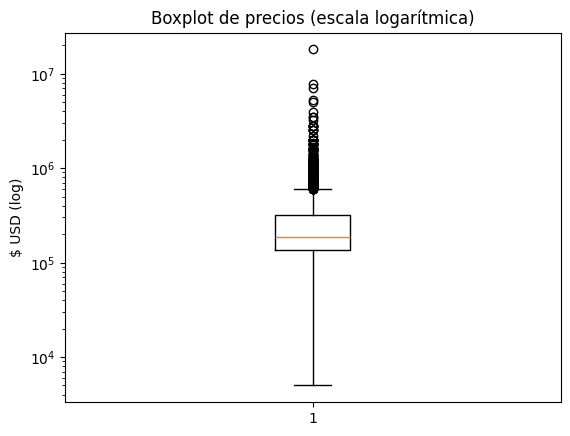

In [77]:
plt.boxplot(df['price_usd'])
plt.yscale('log')
plt.title('Boxplot de precios (escala logarítmica)')
plt.ylabel('$ USD (log)')
plt.show()

In [78]:
# Eliminio outliers en price_usd usando percentiles 1 y 99
lower = df['price_usd'].quantile(0.01)
upper = df['price_usd'].quantile(0.99)
df = df[(df['price_usd'] >= lower) & (df['price_usd'] <= upper)]

In [79]:
# Rellenar surface_total basado en el precio por m2 mediano según tipo de propiedad
## Precio promedio por m2 según tipo de propiedad
df['price_per_m2'] = df['price_usd'] / df['surface_total']
price_per_m2_median = df.groupby('property_type')['price_per_m2'].transform('median')

## Rellenar surface_total donde falta
df['surface_total'] = df['surface_total'].fillna(df['price_usd'] / price_per_m2_median)

## Eliminar columna temporal price_per_m2
df = df.drop(columns=['price_per_m2'])

In [80]:
# Rellenar surface_cover basado en la relación mediana entre surface_total y surface_covered según tipo de propiedad
## Proporcion mediana entre surface_total y surface_covered según tipo de propiedad
df['total_vs_covered'] = df['surface_total'] / df['surface_covered']
factor_median = df.groupby('property_type')['total_vs_covered'].transform('median')

## Rellenar surface_total donde falta
df['surface_covered'] = df['surface_covered'].fillna(df['surface_total'] / factor_median)

## Eliminar columna temporal total_vs_covered
df = df.drop(columns=['total_vs_covered'])

In [81]:
# Consistencia entre surface_total y surface_covered
df.loc[df['surface_covered'] > df['surface_total'], 'surface_covered']

1827       83.0
5170      155.0
24145      45.0
24148      45.0
38072      45.0
          ...  
901433    210.0
901434    210.0
963880    120.0
971279    500.0
973944    147.0
Name: surface_covered, Length: 83, dtype: float64

In [82]:
porcentaje_faltantes = df.isna().sum() / len(df) * 100
print(porcentaje_faltantes[porcentaje_faltantes > 0].sort_values(ascending=False))

Series([], dtype: float64)


In [83]:
# Exportar data limpia
df.to_csv("../data/data_cleaned.csv", index=False)